# Machine Learning Online Class - Exercise 4 Neural Network Learning

In [17]:
import numpy as np
from scipy.optimize import fmin_bfgs
from scipy.io import loadmat
import random
import matplotlib.pyplot as plt

In [18]:
#Initialization
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

## =========== Part 1: Loading and Visualizing Data ============= 

In [20]:
data = loadmat("ex4data1.mat")
X = data['X']
y = data['y']
X.shape, y.shape

((5000, 400), (5000, 1))

In [21]:
#randomly select 100 data points to display
rand_indices = random.sample(range(X.shape[0]), 100)
sel = X[rand_indices,:]

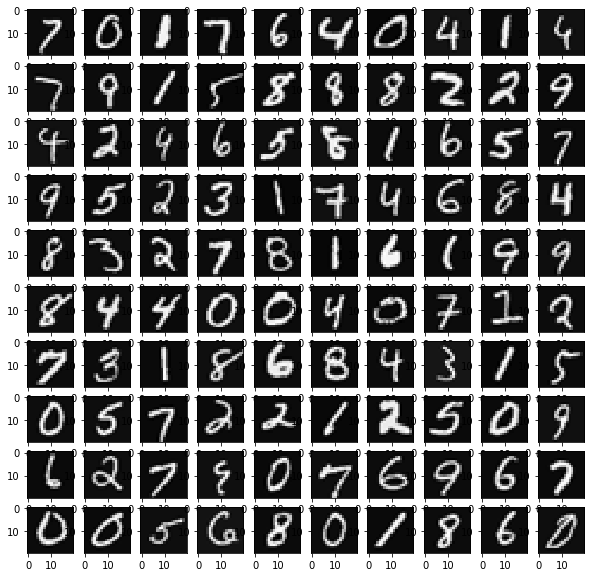

In [22]:
#Display the data as images
fig0, ax = plt.subplots(10,10,figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(sel[10*i+j].reshape(20,20, order='F'), cmap='gray')#order 'F' orders by column, like fortran

## ================ Part 2: Loading Parameters ================

In [26]:
#We load some pre-initialized parameters
nn_params = loadmat("ex4weights.mat")
Theta1 = nn_params['Theta1']
Theta2 = nn_params['Theta2']
Theta1.shape, Theta2.shape

((25, 401), (10, 26))

# Backpropagation

<img src="nnet.png" width=200/>
<br >
$$J(\Theta)=-\frac{1}{m}\sum_{\alpha=1}^{m}\sum_{i=1}^{n_L} \left[y_{i,\alpha}\log(a^{(L)}_{i})+(1-y_{i,\alpha})\log(1-a^{(L)}_{i}))\right]+\frac{\lambda}{2m}\sum_{k=1}^{L-1}\sum_{s=1}^{n_{k}}\sum_{r=1}^{n_{k+1}}\left(\Theta_{rs}^{(k)}\right)^2,$$
where
$$a_{i}^{(k)}=h(z^{(k)}_{i}),$$
$$a_{i}^{(1)}=x_{i,\alpha},\ 1\leq\alpha\leq m,$$
and
$$z^{(k)}_{i}=\sum_{j=1}^{n_{k-1}}\Theta^{(k-1)}_{ij}a^{(k-1)}_j.$$
If the sigmoid is used as activation function then
$$h(z)=\frac{1}{1+e^{-z}}.$$
NOTE: The vectors $y_{\alpha}$ are one-hot encodings for the different classes in the classification problem.

The elements of the gradient can be computed as
$$\frac{\partial J}{\partial\Theta_{ij}^{(k)}}=\left(\begin{array}{ccc}
\frac{\partial J}{\partial a_{1}^{(L)}} & \cdots &\frac{\partial J}{\partial a_{n_L}^{(L)}}\\
\end{array}\right)
\left(\begin{array}{ccc}
\frac{\partial a_{1}^{(L)}}{\partial a_{1}^{(L-1)}} & \cdots & \frac{\partial a_{1}^{(L)}}{\partial a_{n_{L-1}}^{(L-1)}}\\
\vdots & \ddots & \vdots \\
\frac{\partial a_{n_L}^{(L)}}{\partial a_{1}^{(L-1)}} & \cdots & \frac{\partial a_{n_L}^{(L)}}{\partial a_{n_{L-1}}^{(L-1)}}\\
\end{array}\right)\cdots
\left(\begin{array}{ccc}
\frac{\partial a_{1}^{(k+2)}}{\partial a_{1}^{(k+1)}} & \cdots & \frac{\partial a_{1}^{(k+2)}}{\partial a_{n_{k+1}}^{(k+1)}}\\
\vdots & \ddots & \vdots \\
\frac{\partial a_{n_{k+2}}^{(k+2)}}{\partial a_{1}^{(k+1)}} & \cdots & \frac{\partial a_{n_{k+2}}^{(k+2)}}{\partial a_{n_{k+1}}^{(k+1)}}\\
\end{array}\right)
\left(\begin{array}{c}
\frac{\partial a_{1}^{(k+1)}}{\partial\Theta_{ij}^{(k)}}\\
\vdots\\
\frac{\partial a_{n_{k+1}}^{(k+1)}}{\partial\Theta_{ij}^{(k)}}\\
\end{array}\right)+\frac{\lambda}{m}\Theta_{ij}^{(k)}(1-\delta_{j0}),$$
where
$$\frac{\partial J}{\partial a_i^{(L)}}=-\frac{1}{m}\sum_{\alpha=1}^{m}\left(\frac{y_{i,\alpha}}{a_i^{(L)}}-\frac{1-y_{i,\alpha}}{1-a_i^{(L)}}\right)=\frac{1}{m}\sum_{\alpha=1}^{m}\frac{(a_i^{(L)}-y_{i,\alpha})}{a_i^{(L)}(1-a_i^{(L)})},$$
$$\frac{\partial a_{r}^{(k+1)}}{\partial a_{s}^{(k)}}=\frac{\partial h}{\partial z_r^{(k+1)}}\frac{\partial z_r^{(k+1)}}{\partial a_{s}^{(k)}}=h'(z_r^{(k+1)})\Theta_{rs}^{(k)},$$
and
$$\frac{\partial a_{r}^{(k+1)}}{\partial\Theta_{ij}^{(k)}}=\frac{\partial h}{\partial z_r^{(k+1)}}\frac{\partial z_r^{(k+1)}}{\partial\Theta_{ij}^{(k)}}=h'(z_r^{(k+1)})a_j^{(k)}\delta_{ri}.$$

We have then that for $k=L-1$
$$\frac{\partial J}{\partial\Theta_{ij}^{(L-1)}}=\sum_{l=1}^{n_{L}}\frac{\partial J}{\partial a_l^{(L)}}\frac{\partial a_l^{(L)}}{\partial \Theta_{ij}^{(L-1)}}=\frac{1}{m}\sum_{\alpha=1}^{m}\frac{(a_i^{(L)}-y_{i,\alpha})}{a_i^{(L)}(1-a_i^{(L)})}h'(z_i^{(L)})a_j^{(L-1)}=\frac{1}{m}\sum_{\alpha=1}^{m}\delta_i^{(L)}a_j^{(L-1)},$$
while for, say, $k=L-3$
\begin{align}
\frac{\partial J}{\partial\Theta_{ij}^{(L-3)}}&=\sum_{s=1}^{n_{L-2}}\sum_{r=1}^{n_{L-1}}\sum_{l=1}^{n_{L}}\frac{\partial J}{\partial a_l^{(L)}}\frac{\partial a_l^{(L)}}{\partial a_r^{(L-1)}}\frac{\partial a_r^{(L-1)}}{\partial a_s^{(L-2)}}\frac{\partial a_s^{(L-2)}}{\partial \Theta_{ij}^{(L-3)}}\\
&=\frac{1}{m}\sum_{\alpha=1}^{m}\underbrace{\sum_{r=1}^{n_{L-1}}\underbrace{\sum_{l=1}^{n_{L}}\underbrace{\frac{(a_l^{(L)}-y_{l,\alpha})}{a_l^{(L)}(1-a_l^{(L)})}h'(z_l^{(L)})}\Theta_{lr}^{(L-1)}h'(z_r^{(L-1)})}\Theta_{ri}^{(L-2)}h'(z_i^{(L-2)})}a_j^{(L-3)}\\
&=\frac{1}{m}\sum_{\alpha=1}^{m}\delta_i^{(L-2)}a_j^{(L-3)},
\end{align}
that is, in general
$$\frac{\partial J}{\partial\Theta_{ij}^{(k)}}=\frac{1}{m}\sum_{\alpha=1}^{m}\delta_i^{(k+1)}a_j^{(k)},$$
where
$$\delta_r^{(k)}=\sum_{l=1}^{n_{k+1}}\delta_l^{(k+1)}\Theta_{lr}^{(k)}h'(z_r^{(k)}),$$
and
$$\delta_s^{(L)}=\frac{(a_s^{(L)}-y_{s,\alpha})}{a_s^{(L)}(1-a_s^{(L)})}h'(z_s^{(L)}).$$
In the case where a sigmoid is used as activation function
$$h'(z_r^{(k)})=h(z_r^{(k)})(1-h(z_r^{(k)}))=a_r^{(k)}(1-a_r^{(k)}).$$
###--------------------------------------------------------------------------

In [13]:
#Reshape and concatenate several matrices into a single long vector:
import numpy as np

T1 = np.ones((10,11))
T2 = 2*np.ones((10,11))
T3 = 3*np.ones((1,11))

Tvec = np.concatenate((T1.reshape(1,T1.shape[0]*T1.shape[1]),
                       T2.reshape(1,T2.shape[0]*T2.shape[1]),
                       T3.reshape(1,T3.shape[0]*T3.shape[1])),
                      axis=1)
Tvec

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 

In [11]:
#Get matrices back
ind1 = T1.shape[0]*T1.shape[1]
ind2 = T1.shape[0]*T1.shape[1]+T2.shape[0]*T2.shape[1]
Tvec[0][ind1:ind2].reshape((T2.shape[0],T2.shape[1]))

array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]])

In [14]:
#Create a random matrix
e = 0.2
R = e * (2*np.random.rand(3,4)-1)
R

array([[-0.14646889, -0.01465198,  0.15299033, -0.1355301 ],
       [-0.15304847,  0.17829969, -0.17226624,  0.06117708],
       [-0.19545921, -0.07655205,  0.16055267, -0.05418693]])